#ATSC 507 Assignment XIII

In [1]:
__author__ = 'Yingkai (Kyle) Sha'
__email__  = 'yingkai@eos.ubc.ca'

In [2]:
from IPython.core.display import HTML
HTML(open("../custom.css", "r").read())

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Content
1. [**WRF Cumulus Schemes**](#WRF-Cumulus-Schemes)
1. [**Comparing CPU time**](#Comparing-CPU-time)
  2. [Short summary](#Short-summary)
1. [**Comparing Results**](#Comparing-Results)
  2. [Accumulate total cumulus precipitation](#Accumulate-total-cumulus-precipitation)
  2. [Latent heat](#Latent-heat)
  2. [Short summary](#Short-summary)
1. [**Conclusion**](#Conclusion)

#WRF Cumulus Schemes

* **Kain-Fritsch** 
    * cu_physics = 1, default
    * Prognostic, single plume, mass-flux form scheme.
   
* **Betts-Miller-Janjic**
    * cu_physics = 2
    * Diagnostic, single plume, non-mass-flux type scheme.
* **Simplified Arakawa-Schubert**
    * cu_physics = 14
    * Prognostic, spectral plume, non-mass-flux type scheme.
    * Simplified from original/old A.-S. scheme, operated in NCEP-GFS
    
*My initial plan including Zhang-McFarlane, but it is not happy with WRF-ARW's default microphysics sets, so I tried Simplified Arakawa-Schubert instead.*

**References**
* [1] Kain, J. S. The Kain-Fritsch convective parameterization: an update. *J. Appl. Meteor.* 43, no. 1 (2004): 170-181.
* [2] Betts, A. K. A new convective adjustment scheme. Part I: Observational and theoretical basis. *Quart. J. Roy. Meteor. Soc.* 112, no. 473 (1986): 677-691.
* [3] Han, J., and Hua-Lu Pan. Revision of convection and vertical diffusion schemes in the NCEP global forecast system. *Wea. Forecasting* 26, no. 4 (2011): 520-533.

# Comparing CPU time

**Kain-Fritsch** (cu_physics = 1)

<img src="_figures/ATSC507_KF_time.PNG" width=350 align="left"/>

**Betts-Miller-Janjic** (cu_phyics = 2)

<img src="_figures/ATSC507_BMJ_time.PNG" width=350 align="left"/>

**Simplified Arakawa-Schubert** (cu_physics = 14)

<img src="_figures/ATSC507_SAS_time.PNG" width=350 align="left"/>

## Short summary

* *K.-F.* ran faster than *B.-M.-J.* and *Simplified A.-K.*. This is out of my expectation because *K.-F.* seems to be one of the most complex schemes in WRF-ARW. Technically, *B.-M.-J.* should be the fastest because it is a diagnostic and exmplicit scheme, but it ends out to be the lowest. Then there is no reason for us to consider *B.-M.-J.*, since its advantage is speed. *Simplified A.-K.* is as slow as *B.-M.-J.*.
* Reasons to explain the CPU time difference could be *K.-F.*'s mass-flux feature which makes it does well in high resolution (nested) domain with strong convection (here, hurricane) case.
* Another reason which could bias the CPU time is the maintainence of UBC-Orcinus, which means the nodes in use is fluctuant:

<img src="_figures/Orcinus.PNG" width=600 align="center"/>

# Comparing Results

##Modules & tools & data

In [4]:
import numpy as np
import netCDF4 as nc
#from skewt import SkewT
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import cm
from mpl_toolkits.basemap import Basemap
#from matplotlib.colorbar import ColorbarBase as CBarBase
% matplotlib inline

In [5]:
KFd01_obj  = nc.Dataset('_data/ATSC 507 WRF III/KF_wrfout_d01_2005-08-28.nc')
KFd02_obj  = nc.Dataset('_data/ATSC 507 WRF III/KF_wrfout_d02_2005-08-28.nc')
BMJd01_obj = nc.Dataset('_data/ATSC 507 WRF III/BMJ_wrfout_d01_2005-08-28.nc')
BMJd02_obj = nc.Dataset('_data/ATSC 507 WRF III/BMJ_wrfout_d02_2005-08-28.nc')
SASd01_obj = nc.Dataset('_data/ATSC 507 WRF III/SAS_wrfout_d01_2005-08-28.nc')
SASd02_obj = nc.Dataset('_data/ATSC 507 WRF III/SAS_wrfout_d02_2005-08-28.nc')

In [6]:
print(KFd01_obj.variables.keys())

[u'time', u'DateTime', u'year', u'month', u'day', u'hour', u'minute', u'pressure', u'eta', u'p_top', u'lat', u'lon', u'Z_sfc', u'SST', u'T_sfc', u'p_sfc', u'slp', u'T_2m', u'theta_2m', u'Td_2m', u'r_v_2m', u'q_2m', u'rh_2m', u'u_10m_gr', u'v_10m_gr', u'u_10m_tr', u'v_10m_tr', u'ws_10m', u'wd_10m', u'precip_g', u'precip_c', u'pblh', u'nest_p', u'r_cloud', u'r_rain', u'Z_p', u'T_p', u'theta_p', u'Td_p', u'r_v_p', u'q_p', u'rh_p', u'u_tr_p', u'v_tr_p', u'ws_p', u'wd_p', u'w_p', u'pvo_p', u'avo_p', u'SW_d', u'LW_d', u'albedo', u'SH', u'LH', u'u_star', u'LWP', u'IWP', u'LandMask', u'LandUse', u'SeaIce']


In [7]:
title_name = ['(a) K.-F. 2005-08-28 03:00:00', '(b) K.-F. 2005-08-28 09:00:00', \
              '(c) B.-M.-J. 2005-08-28 03:00:00', '(d) B.-M.-J. 2005-08-28 09:00:00', \
              '(e) Simplified A.-S. 2005-08-28 03:00:00', '(f) Simplified A.-S. 2005-08-28 09:00:00']

In [8]:
lat01 = KFd01_obj.variables['lat'][:]
lon01 = KFd01_obj.variables['lon'][:]
lat02 = KFd02_obj.variables['lat'][:]
lon02 = KFd02_obj.variables['lon'][:]
plev = KFd01_obj.variables['pressure'][:]

In [9]:
latlim01 = [lat01.min(), lat01.max()]
lonlim01 = [lon01.min(), lon01.max()]
latlim02 = [lat02.min(), lat02.max()]
lonlim02 = [lon02.min(), lon02.max()]

In [10]:
mapkey01=dict(projection='merc',\
             llcrnrlon=lonlim01[0], llcrnrlat=latlim01[0],\
             urcrnrlon=lonlim01[1], urcrnrlat=latlim01[1],\
             resolution='l')
mapkey02=dict(projection='merc',\
             llcrnrlon=lonlim02[0], llcrnrlat=latlim02[0],\
             urcrnrlon=lonlim02[1], urcrnrlat=latlim02[1],\
             resolution='i')

In [11]:
def draw_contour(mapkey, lon, lat, precip, lev, CMap, title_name, ax):
    proj=Basemap(**mapkey); proj.ax = ax
    proj.drawcoastlines(linewidth=1, color=[0.35, 0.35, 0.35])
    proj.drawstates(color=[0.35, 0.35, 0.35], linewidth=0.5)
    proj.drawparallels(np.arange(0, 90, np.round((mapkey['urcrnrlon']-mapkey['llcrnrlon'])/5)), \
                       labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
    proj.drawmeridians(np.arange(180, 360, np.round((mapkey['urcrnrlat']-mapkey['llcrnrlat'])/3)), \
                       labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
    x, y=proj(lon, lat)
    #
    CS=proj.contourf(x, y, precip, lev, cmap=CMap, extend='max')
    x_frame, y_frame = np.meshgrid([x.min(), x.max()], [y.min(), y.max()])
    proj.plot(x_frame, y_frame, 'k-', linewidth=3)
    proj.plot(x_frame.T, y_frame.T, 'k-', linewidth=3)
    ax.set_title(title_name, fontweight='bold', fontsize=14, y=1.01)
    return proj, CS

In [12]:
# nonlinear colormap, borrowed from Robert Hetland <hetland@tamu.edu>, under MIT license.
# http://protracted-matter.blogspot.ca/2012/08/nonlinear-colormap-in-matplotlib.html
from numpy import *
from matplotlib.colors import LinearSegmentedColormap
class nlcmap(LinearSegmentedColormap):
    name = 'nlcmap'    
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = asarray(levels, dtype='float64')
        self._x = self.levels / self.levels.max()
        self._y = linspace(0.0, 1.0, len(self.levels))
    def __call__(self, xi, alpha=1.0, **kw):
        """docstring for fname"""
        yi = interp(xi, self._x, self._y)
        return self.cmap(yi, alpha)

## Accumulate total cumulus precipitation

In [13]:
precip_lev = [1, 2.5, 5, 7.5, 10, 15, 25, 50, 75]
CMap = nlcmap(cm.GMT_no_green, precip_lev)

**Domain 01**

In [14]:
KFprecip01 =  KFd01_obj.variables['precip_c'][:]
BMJprecip01 = BMJd01_obj.variables['precip_c'][:]
SASprecip01 =  SASd01_obj.variables['precip_c'][:]

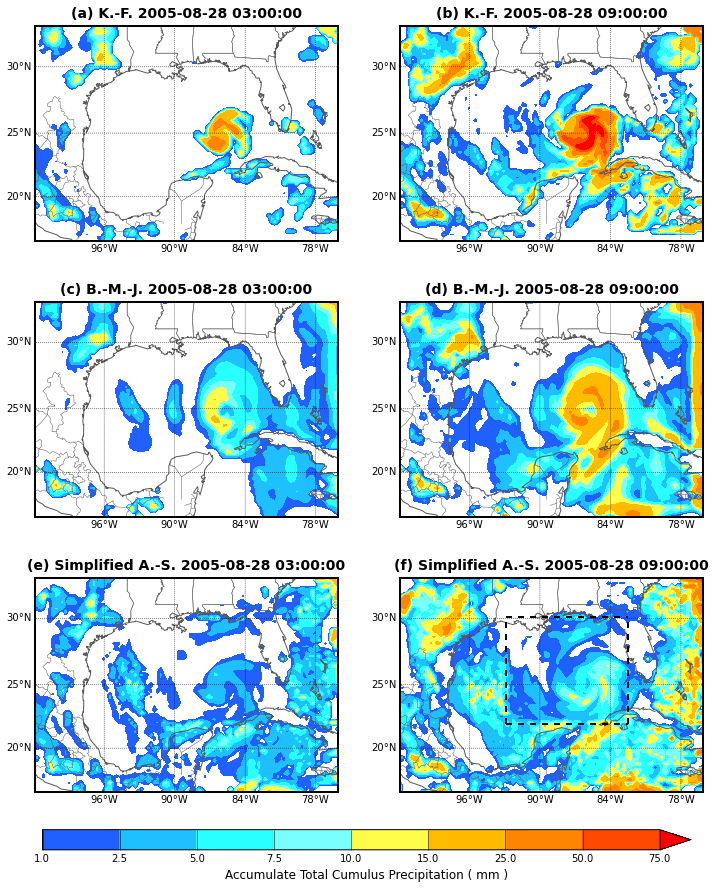

In [15]:
fig = plt.figure(figsize=(12, 14))
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid((3, 2), (1, 1), colspan=1, rowspan=1)
ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=1, rowspan=1)
ax6 = plt.subplot2grid((3, 2), (2, 1), colspan=1, rowspan=1)
draw_contour(mapkey01, lon01, lat01, KFprecip01[1, :, :],  precip_lev, CMap, title_name[0], ax1)
draw_contour(mapkey01, lon01, lat01, KFprecip01[3, :, :],  precip_lev, CMap, title_name[1], ax2)
draw_contour(mapkey01, lon01, lat01, BMJprecip01[1, :, :], precip_lev, CMap, title_name[2], ax3)
draw_contour(mapkey01, lon01, lat01, BMJprecip01[3, :, :], precip_lev, CMap, title_name[3], ax4)
draw_contour(mapkey01, lon01, lat01, SASprecip01[1, :, :], precip_lev, CMap, title_name[4], ax5)
proj, CS = draw_contour(mapkey01, lon01, lat01, SASprecip01[3, :, :], \
                        precip_lev, CMap, title_name[5], ax6)
x, y=proj(lon02, lat02)
x_frame, y_frame = np.meshgrid([x.min(), x.max()], [y.min(), y.max()])
proj.plot(x_frame, y_frame, 'k--', linewidth=2)
proj.plot(x_frame.T, y_frame.T, 'k--', linewidth=2)
# bottom colorbar
cax  = fig.add_axes([0.135, 0.075, 0.75, 0.02])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('Accumulate Total Cumulus Precipitation ( mm )', fontsize=12)
CBar.ax.tick_params(axis='x', length=20)
CBar.set_ticks(precip_lev)

**Nested domain 02**

In [16]:
KFprecip02 =  KFd02_obj.variables['precip_c'][:]
BMJprecip02 = BMJd02_obj.variables['precip_c'][:]
SASprecip02 =  SASd02_obj.variables['precip_c'][:]

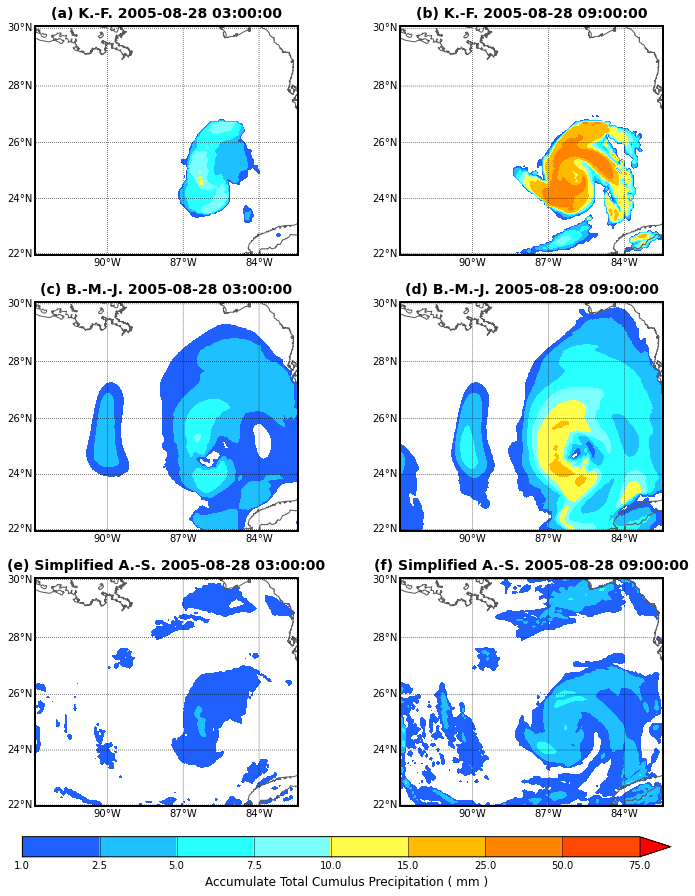

In [17]:
fig = plt.figure(figsize=(12, 14))
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid((3, 2), (1, 1), colspan=1, rowspan=1)
ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=1, rowspan=1)
ax6 = plt.subplot2grid((3, 2), (2, 1), colspan=1, rowspan=1)
draw_contour(mapkey02, lon02, lat02,  KFprecip02[1, :, :], precip_lev, CMap, title_name[0], ax1)
draw_contour(mapkey02, lon02, lat02,  KFprecip02[3, :, :], precip_lev, CMap, title_name[1], ax2)
draw_contour(mapkey02, lon02, lat02, BMJprecip02[1, :, :], precip_lev, CMap, title_name[2], ax3)
draw_contour(mapkey02, lon02, lat02, BMJprecip02[3, :, :], precip_lev, CMap, title_name[3], ax4)
draw_contour(mapkey02, lon02, lat02, SASprecip02[1, :, :], precip_lev, CMap, title_name[4], ax5)
_, CS = draw_contour(mapkey02, lon02, lat02, SASprecip02[3, :, :], \
                     precip_lev, CMap, title_name[5], ax6)
# bottom colorbar
cax  = fig.add_axes([0.135, 0.075, 0.75, 0.02])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('Accumulate Total Cumulus Precipitation ( mm )', fontsize=12)
CBar.ax.tick_params(axis='x', length=20)
CBar.set_ticks(precip_lev)

##Latent heat

In [18]:
LH_lev = np.arange(-150, 1500+150, 150)
CMap = plt.cm.RdBu_r#Spectral_r

**Domain 01**

In [19]:
KFLH01 = KFd01_obj.variables['LH'][:]
BMJLH01 = BMJd01_obj.variables['LH'][:]
SASLH01 = SASd01_obj.variables['LH'][:]

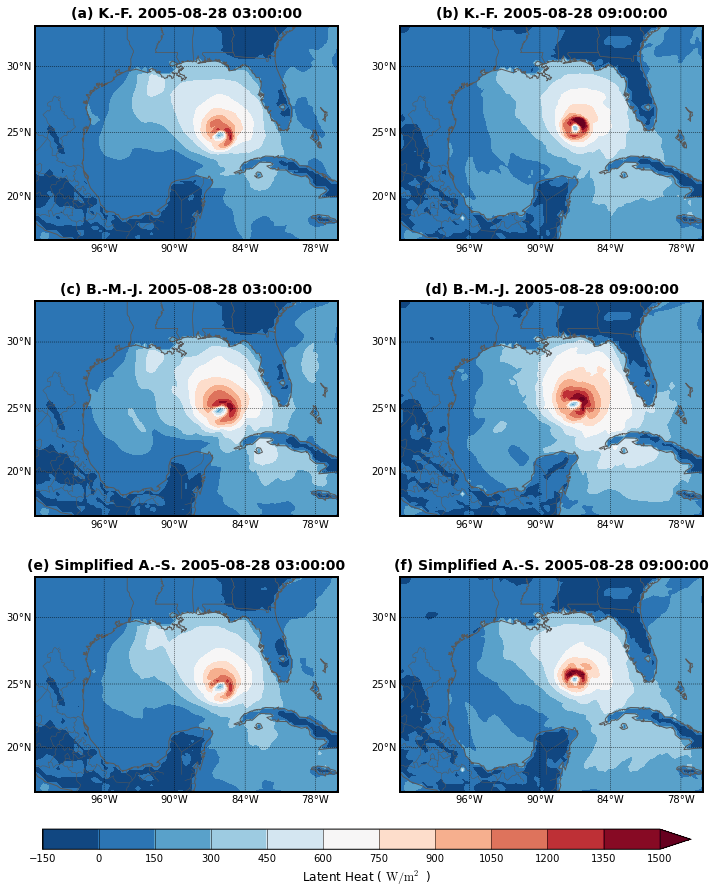

In [20]:
fig = plt.figure(figsize=(12, 14))
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid((3, 2), (1, 1), colspan=1, rowspan=1)
ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=1, rowspan=1)
ax6 = plt.subplot2grid((3, 2), (2, 1), colspan=1, rowspan=1)
draw_contour(mapkey01, lon01, lat01, KFLH01[1, :, :], LH_lev, CMap, title_name[0], ax1)
draw_contour(mapkey01, lon01, lat01, KFLH01[3, :, :], LH_lev, CMap, title_name[1], ax2)
draw_contour(mapkey01, lon01, lat01, BMJLH01[1, :, :], LH_lev, CMap, title_name[2], ax3)
draw_contour(mapkey01, lon01, lat01, BMJLH01[3, :, :], LH_lev, CMap, title_name[3], ax4)
draw_contour(mapkey01, lon01, lat01, SASLH01[1, :, :], LH_lev, CMap, title_name[4], ax5)
proj, CS = draw_contour(mapkey01, lon01, lat01, SASLH01[3, :, :], LH_lev, CMap, title_name[5], ax6)
cax  = fig.add_axes([0.135, 0.075, 0.75, 0.02])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('Latent Heat ( $\mathrm{W/m^2}$ )', fontsize=12)
CBar.ax.tick_params(axis='x', length=20)
CBar.set_ticks(LH_lev)

**Nest domain 02**

In [21]:
KFLH02 = KFd02_obj.variables['LH'][:]
BMJLH02 = BMJd02_obj.variables['LH'][:]
SASLH02 = SASd02_obj.variables['LH'][:]

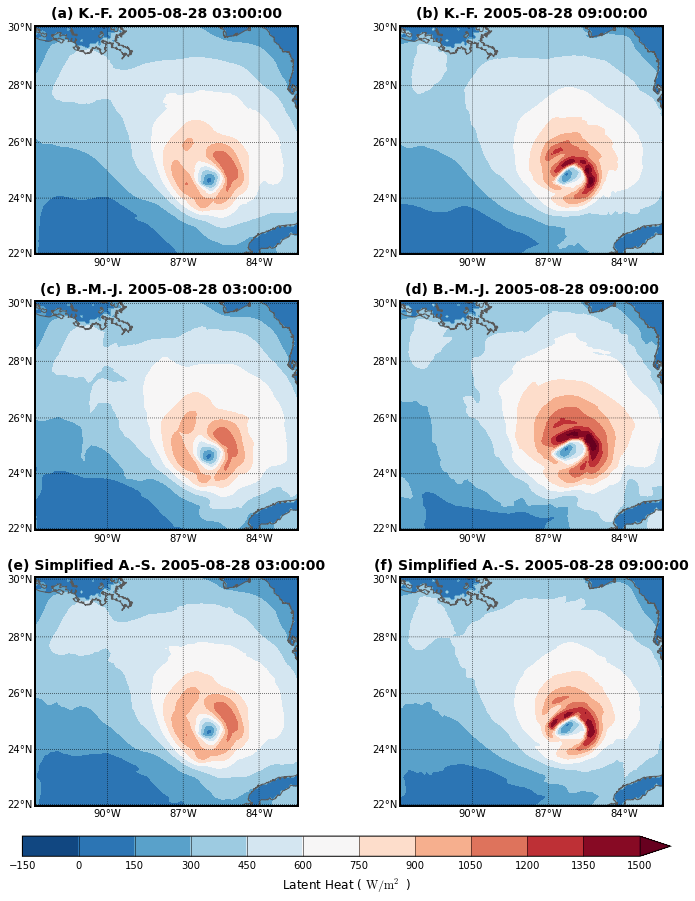

In [22]:
fig = plt.figure(figsize=(12, 14))
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid((3, 2), (1, 1), colspan=1, rowspan=1)
ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=1, rowspan=1)
ax6 = plt.subplot2grid((3, 2), (2, 1), colspan=1, rowspan=1)
draw_contour(mapkey02, lon02, lat02,  KFLH02[1, :, :], LH_lev, CMap, title_name[0], ax1)
draw_contour(mapkey02, lon02, lat02,  KFLH02[3, :, :], LH_lev, CMap, title_name[1], ax2)
draw_contour(mapkey02, lon02, lat02, BMJLH02[1, :, :], LH_lev, CMap, title_name[2], ax3)
draw_contour(mapkey02, lon02, lat02, BMJLH02[3, :, :], LH_lev, CMap, title_name[3], ax4)
draw_contour(mapkey02, lon02, lat02, SASLH02[1, :, :], LH_lev, CMap, title_name[4], ax5)
_, CS = draw_contour(mapkey02, lon02, lat02, SASLH02[3, :, :], LH_lev, CMap, title_name[5], ax6)
cax  = fig.add_axes([0.135, 0.075, 0.75, 0.02])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('Latent Heat ( $\mathrm{W/m^2}$ )', fontsize=12)
CBar.ax.tick_params(axis='x', length=20)
CBar.set_ticks(LH_lev)

## Short summary

* Schemes all did well in energy (latent heat) computation, but the cumulus precipitation results show a big difference. Which means the main difference of these schemes are the consideration of water budget equation. 
* *K.-F.* did very well in cumulus precipitation results, which perserved the "shape of hurricane" in both d01 and nested d02. So again, we see the advantage of mass-flux scheme.
* *K.-F.* scheme produced strong precipitation, without real time observations, we don't know if that's "real" or an overestimation
* *B.-M.-J.*'s precipitation results in unphysical, we see large precipitation amount in unrelavent regions which are hundered of km away from the hurricane's controlling area in d01. And in d02, compared with other's results, it seems triggers too easy, and rain too much. 
* *Simplified A.-K.* looks moderated, which is at least better than *B.-M.-J.* in nested d02, but we still see large precipitation amount in unrelavent regions in d01.
* The black line in *Simplified A.-K.*'s fig.f for precipitation shows a sharp "interface" between d01 and d02, which means that *Simplified A.-K.* is not good at handling the exchange between d01 and nested d02 domains. 

# Conclusion

* **Kain-Fritsch** is the best in WRF-ARW's hurricane Katrina case with two domains.
* **Betts-Miller-Janjic** is slow and bad, not a good idea.